# Importing the required libraries

In [9]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from torchvision import models
from sklearn.metrics import classification_report

# Loading the Test Dataset

In [10]:
transform = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_dir = "/Users/emmanuelgeorgep/Desktop/tempp1/Dataset/Test"
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print("Test samples:", len(test_dataset))

Test samples: 2000


# Class of Student Model for Feature Based KD

In [11]:
class Student_FE(nn.Module):
    def __init__(self, num_classes=2, f=32, k=3, u=256, r=0.5):
        super(Student_FE, self).__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=f, kernel_size=k, padding=1),
            nn.BatchNorm2d(f),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=f, out_channels=f, kernel_size=k, padding=1),
            nn.BatchNorm2d(f),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=f, out_channels=f, kernel_size=k, padding=1),
            nn.BatchNorm2d(f),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=f, out_channels=f, kernel_size=k, padding=1),
            nn.BatchNorm2d(f),
            nn.MaxPool2d(kernel_size=2),
        )

        self.flatten = nn.Sequential(nn.Flatten(),nn.Linear(f * 8 * 8, 512))
        

        self.classifier = nn.Sequential( 
            nn.Linear(512, 256),# assuming input image size is 128x128
            nn.ReLU(),
            nn.BatchNorm1d(u),
            nn.Dropout(r),
            nn.Linear(u, num_classes)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.flatten(x)
        conv_output = x
        x = self.classifier(x)
        return x,conv_output

# Class of Teacher Model

In [12]:
class BinaryResNet18(nn.Module):
    def __init__(self, pretrained=True):
        super(BinaryResNet18, self).__init__()

        self.base_model = models.resnet18(pretrained=pretrained)
        
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(num_features, 2)  # Binary classification

    def forward(self, x):
        return self.base_model(x)

# Class of Student Model for KL Divergence

In [13]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=2, f=32, k=3, u=256, r=0.5):
        super(CustomCNN, self).__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=f, kernel_size=k, padding=1),
            nn.BatchNorm2d(f),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=f, out_channels=f, kernel_size=k, padding=1),
            nn.BatchNorm2d(f),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=f, out_channels=f, kernel_size=k, padding=1),
            nn.BatchNorm2d(f),
            nn.MaxPool2d(kernel_size=2),
        )

        self.flatten = nn.Flatten()

        self.classifier = nn.Sequential(
            nn.Linear(f * 16 * 16, u),  # assuming input image size is 128x128
            nn.ReLU(),
            nn.BatchNorm1d(u),
            nn.Dropout(r),
            nn.Linear(u, num_classes)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

# Testing Code for Feature Based KD

In [14]:
def test_model(model, test_loader, device, class_names):
    model.eval()
    model.to(device)
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            outputs = outputs[0]
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    print(classification_report(all_labels, all_preds, target_names=class_names))

# Testing Code for KL Divergence KD models

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def test_model_KL(model, test_loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            print(outputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')  # use 'weighted' if class imbalance matters
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

# Teacher Model

In [16]:
teacher = BinaryResNet18(pretrained=False).to('mps')
teacher.load_state_dict(torch.load("/Users/emmanuelgeorgep/Desktop/tempp1/ModelWeights/teacher-KL.pth"))
test_model_KL(teacher, test_loader, torch.device('mps'), test_dataset.classes)

tensor([[ 1.5616, -1.7557],
        [ 4.2486, -4.9890],
        [ 3.1203, -3.7223],
        [ 2.6640, -3.3673],
        [ 3.2497, -3.4352],
        [ 0.5428, -1.4546],
        [-3.3293,  1.1423],
        [-4.8022,  2.4028],
        [ 0.5428, -1.4546],
        [-2.0728,  0.4083],
        [-3.7187,  1.5305],
        [-2.0352,  0.5794],
        [ 3.8249, -4.3793],
        [-1.6334,  0.1032],
        [-4.2519,  2.0259],
        [ 2.7052, -3.1491],
        [ 0.8280, -1.1672],
        [ 3.0960, -3.0216],
        [ 2.1119, -2.5369],
        [ 2.1243, -2.5529],
        [ 1.2492, -1.6481],
        [ 2.0528, -2.4362],
        [ 2.4300, -2.8699],
        [ 3.7141, -4.4385],
        [ 1.9042, -2.3581],
        [ 2.0506, -2.5011],
        [ 2.0042, -2.4449],
        [ 1.1026, -1.5349],
        [ 1.1526, -1.6923],
        [ 3.2130, -3.1966],
        [ 1.5226, -2.1573],
        [ 1.2782, -1.8265]], device='mps:0')
tensor([[ 2.0900, -2.7828],
        [ 1.9444, -2.4229],
        [ 3.8012, -4.4644],
   

# Student Model

In [17]:
student = CustomCNN(num_classes=len(test_dataset.classes)).to('mps')
student.load_state_dict(torch.load("/Users/emmanuelgeorgep/Desktop/tempp1/ModelWeights/student-KL.pth"))
test_model_KL(student, test_loader, torch.device('mps'), test_dataset.classes)

tensor([[-0.7950,  0.0817],
        [ 2.5535, -2.5129],
        [ 3.1420, -3.5672],
        [ 2.1934, -3.3015],
        [-0.2278, -0.0755],
        [ 0.8213, -2.1756],
        [-2.8205,  1.4360],
        [-2.1540,  0.2935],
        [ 0.8213, -2.1756],
        [ 0.2238, -0.8913],
        [-1.5624,  0.0574],
        [ 0.7131, -1.7263],
        [ 1.3845, -1.5373],
        [ 1.1601, -2.3332],
        [-1.3061, -0.2098],
        [ 1.7063, -1.6692],
        [ 1.8140, -2.0577],
        [ 1.8276, -2.3240],
        [ 1.3496, -1.4089],
        [ 1.2552, -1.3040],
        [ 1.6461, -1.8908],
        [ 1.5870, -1.8129],
        [ 1.3977, -1.6201],
        [ 2.7336, -2.7374],
        [ 2.7144, -3.1416],
        [ 2.7283, -3.0537],
        [ 1.0468, -1.2708],
        [ 0.7986, -0.7469],
        [ 1.1754, -1.1541],
        [ 1.4240, -1.7797],
        [ 2.2233, -1.9563],
        [ 0.5263, -0.1345]], device='mps:0')
tensor([[ 1.8779, -1.5383],
        [ 2.2350, -2.4544],
        [ 2.9191, -2.3628],
   

# KD model - KL Divergence

In [18]:
student_KL = CustomCNN(num_classes=len(test_dataset.classes)).to('mps')
student_KL.load_state_dict(torch.load("/Users/emmanuelgeorgep/Desktop/tempp1/ModelWeights/KD-KL-div.pth"))
test_model_KL(student_KL, test_loader, torch.device('mps'), test_dataset.classes)

tensor([[-0.8346,  0.9632],
        [ 4.8292, -4.3756],
        [ 3.1906, -3.5645],
        [ 1.3625, -1.5018],
        [ 1.1955, -0.5462],
        [-0.7252,  0.1133],
        [-3.1204,  1.9539],
        [-5.3845,  4.1399],
        [-0.7252,  0.1133],
        [-0.4841, -0.6398],
        [-3.6202,  2.1983],
        [-0.4653, -0.1863],
        [ 2.0493, -1.4582],
        [-0.3012, -0.2940],
        [-5.1548,  3.8952],
        [ 2.3468, -3.4214],
        [ 1.5398, -1.2071],
        [ 3.2690, -2.9844],
        [ 1.4988, -2.7135],
        [ 1.5211, -2.8535],
        [ 1.2041, -2.0962],
        [ 3.1991, -4.3886],
        [ 1.7836, -3.1109],
        [ 2.7382, -2.3640],
        [ 1.4722, -2.1184],
        [ 1.7872, -2.6234],
        [ 0.8718, -1.9254],
        [ 1.5450, -2.8599],
        [ 0.9454, -2.2926],
        [ 3.2465, -2.8815],
        [ 2.0611, -3.3164],
        [ 0.0109, -1.1447]], device='mps:0')
tensor([[ 1.4058, -2.6122],
        [ 1.4225, -2.3662],
        [ 4.1325, -3.7836],
   

# KD model - Feature Comparison - MSE

In [19]:
student_MSE = Student_FE().to('mps')
checkpoint = torch.load("/Users/emmanuelgeorgep/Desktop/tempp1/ModelWeights/KD-feature-MSE.pth", map_location=torch.device('cpu'))
student_MSE.load_state_dict(checkpoint)
test_model(student_MSE, test_loader, torch.device('mps'), test_dataset.classes)

              precision    recall  f1-score   support

     Blocked       0.98      0.94      0.96      1000
      Normal       0.94      0.98      0.96      1000

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



# KD model - Feature Comparison - Cosine Similarity

In [20]:
student_Cos = Student_FE().to('mps')
checkpoint = torch.load("/Users/emmanuelgeorgep/Desktop/tempp1/ModelWeights/KD-feature-cos.pth", map_location=torch.device('cpu'))
student_Cos.load_state_dict(checkpoint)
test_model(student_Cos, test_loader, torch.device('mps'), test_dataset.classes)

              precision    recall  f1-score   support

     Blocked       0.98      0.95      0.97      1000
      Normal       0.96      0.98      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



# KD model - Feature Comparison - Combined Loss 

In [21]:
student_Combined = Student_FE().to('mps')
checkpoint = torch.load("/Users/emmanuelgeorgep/Desktop/tempp1/ModelWeights/KD-feature-combined.pth", map_location=torch.device('cpu'))
student_Combined.load_state_dict(checkpoint)
test_model(student_Combined, test_loader, torch.device('mps'), test_dataset.classes)

              precision    recall  f1-score   support

     Blocked       0.97      0.98      0.98      1000
      Normal       0.98      0.97      0.98      1000

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



# Inferences

In [22]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import time

def visualize_predictions(model, image_paths, true_labels, class_names, input_size=(224, 224)):
    # Preprocessing
    transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    model.eval()
    inference_times = []

    plt.figure(figsize=(14, 4))

    for idx, (img_path, true_label) in enumerate(zip(image_paths, true_labels)):
        image = Image.open(img_path).convert("RGB")
        input_tensor = transform(image).unsqueeze(0)

        start_time = time.time()
        with torch.no_grad():
            output = model(input_tensor)
            if isinstance(output, tuple):
                output = output[0]
        end_time = time.time()

        inference_times.append(end_time - start_time)
        predicted_label = torch.argmax(output, dim=1).item()

        plt.subplot(1, 4, idx + 1)
        plt.imshow(image)
        plt.title(f"True: {class_names[true_label]}\nPred: {class_names[predicted_label]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

    avg_time = sum(inference_times) / len(inference_times)
    print(f"\n Average inference time per image: {avg_time:.4f} seconds")
    return avg_time

# Inference from best KD model (Combined Loss)

In [23]:
t1 = visualize_predictions(
    model=student_Combined.to('cpu'),
    image_paths=[
        "/Users/emmanuelgeorgep/Desktop/temp/Dataset/Test/Blocked/image_0279.jpg",
        "/Users/emmanuelgeorgep/Desktop/temp/Dataset/Test/Blocked/image_0343.jpg",
        "/Users/emmanuelgeorgep/Desktop/temp/Dataset/Test/Normal/image_0007.jpg",
        "/Users/emmanuelgeorgep/Desktop/temp/Dataset/Test/Normal/image_0024.jpg"
    ],
    true_labels=[0, 0, 1, 1],
    class_names=["Blocked", "Normal"],
    input_size=(128, 128)
    )

FileNotFoundError: [Errno 2] No such file or directory: '/Users/emmanuelgeorgep/Desktop/temp/Dataset/Test/Blocked/image_0279.jpg'

<Figure size 1400x400 with 0 Axes>

# Inferences from Teacher Model

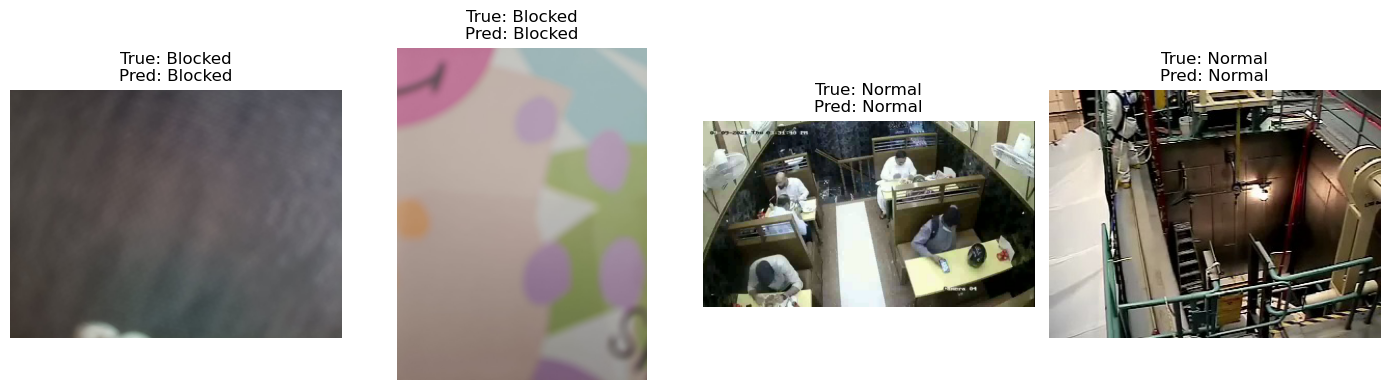


 Average inference time per image: 0.0077 seconds


In [ ]:
t2 = visualize_predictions(
    model=teacher.to('cpu'),
    image_paths=[
        "/Users/emmanuelgeorgep/Desktop/temp/Dataset/Test/Blocked/image_0279.jpg",
        "/Users/emmanuelgeorgep/Desktop/temp/Dataset/Test/Blocked/image_0343.jpg",
        "/Users/emmanuelgeorgep/Desktop/temp/Dataset/Test/Normal/image_0007.jpg",
        "/Users/emmanuelgeorgep/Desktop/temp/Dataset/Test/Normal/image_0024.jpg"
    ],
    true_labels=[0, 0, 1, 1],
    class_names=["Blocked", "Normal"],
    input_size=(128, 128) 
)

# Speedup for the KD model

In [ ]:
print("The student model is faster that the teacher model by",t2/t1,"times.")

The student model is faster that the teacher model by 3.566013793103448 times.
